In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import torch
import random
from glob import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

%matplotlib inline

In [3]:
path = '/content/drive/MyDrive/data/programmers_ai/mlops/COVID_19_XRAY_2/'

In [4]:
train = pd.read_csv(os.path.join(path, 'train/labels.csv'))
train.head

<bound method NDFrame.head of             filename   label
0      image_001.png   covid
1      image_002.png   covid
2      image_003.png  normal
3      image_004.png  normal
4      image_005.png  normal
...              ...     ...
1995  image_1996.png   covid
1996  image_1997.png  normal
1997  image_1998.png   covid
1998  image_1999.png  normal
1999  image_2000.png  normal

[2000 rows x 2 columns]>

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   label     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [6]:
label_encoding = {'normal': 0, 'covid': 1}
train['label'] = train['label'].apply(lambda x: label_encoding[x])

In [7]:
train, valid = train_test_split(train, test_size=0.1, stratify=train['label'], random_state=34)

In [8]:
train.shape, valid.shape

((1800, 2), (200, 2))

In [9]:
train.head()

,filename,label
1938,image_1939.png,0
444,image_445.png,1
1843,image_1844.png,1
1666,image_1667.png,0
106,image_107.png,0


In [10]:
train.iloc[0, 0]

'image_1939.png'

In [11]:
image = cv2.imread(os.path.join(path, 'train/image_1964.png'))
image.shape

(299, 299, 3)

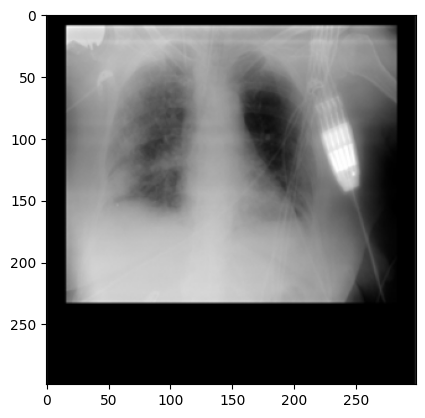

In [12]:
plt.imshow(image)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

## 데이터셋 클래스 정의

In [14]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            label = self.df.iloc[idx, 1]
            return image, label

## 이미지 변환기 정의

In [15]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.ToPILImage(),
                          transforms.Resize((250, 250)),      # 이미지 크기 조정 
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.ToPILImage(),
                          transforms.Resize((250, 250)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

## 데이터셋 및 데이터 로더 생성

In [16]:
dataset_train = ImageDataset(train, img_dir=os.path.join(path,'train/'), transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=os.path.join(path, 'train/'), transform=transform_test)

In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [18]:
from torch.utils.data import DataLoader

batch_size = 10

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=2)

In [19]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=e36b03f634635faa858aafd0b9351f4cb9af2434ed31aacf00353f8950e0d3a2
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch


In [20]:
from efficientnet_pytorch import EfficientNet

In [21]:
models_list = []
# 모델 생성
efficientnet_b5 = EfficientNet.from_pretrained('efficientnet-b5', num_classes=2) 
efficientnet_b6 = EfficientNet.from_pretrained('efficientnet-b6', num_classes=2)
efficientnet_b7 = EfficientNet.from_pretrained('efficientnet-b7', num_classes=2) 

# 장비 할당
efficientnet_b5 = efficientnet_b5.to(device)
efficientnet_b6 = efficientnet_b6.to(device)
efficientnet_b7 = efficientnet_b7.to(device)

# 리스트에 모델 저장
models_list.append(efficientnet_b5)
models_list.append(efficientnet_b6)
models_list.append(efficientnet_b7)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:02<00:00, 45.6MB/s]


Loaded pretrained weights for efficientnet-b5


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth
100%|██████████| 165M/165M [00:02<00:00, 59.7MB/s]


Loaded pretrained weights for efficientnet-b6


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:04<00:00, 55.4MB/s]


Loaded pretrained weights for efficientnet-b7


In [22]:
for idx, model in enumerate(models_list):
    num_parmas = sum(param.numel() for param in model.parameters())
    print(f'모델{idx+1} 파라미터 개수 : {num_parmas}')

모델1 파라미터 개수 : 28344882
모델2 파라미터 개수 : 40740314
모델3 파라미터 개수 : 63792082


In [23]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.6 MB/s eta 0:00:00


In [25]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20 # 총 에폭

# 스케줄러
scheduler1 = get_cosine_schedule_with_warmup(optimizer1, num_warmup_steps=len(loader_train)*3, num_training_steps=len(loader_train)*epochs)

scheduler2 = get_cosine_schedule_with_warmup(optimizer2, num_warmup_steps=len(loader_train)*3, num_training_steps=len(loader_train)*epochs)

scheduler3 = get_cosine_schedule_with_warmup(optimizer3, num_warmup_steps=len(loader_train)*3, num_training_steps=len(loader_train)*epochs)

In [26]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item() 
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [27]:
# 첫 번째 모델 훈련
model_state_dict = train(model=models_list[0],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)

# 첫 번째 모델에 최적 가중치 적용
models_list[0].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.5092
	검증 데이터 손실값 : 0.3006
	정확도 : 0.9050 / 재현율 : 0.8900 / F1 점수 : 0.9036
	### 검증 데이터 손실값 감소 (inf --> 6.0115). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3159
	검증 데이터 손실값 : 0.2242
	정확도 : 0.9200 / 재현율 : 0.8600 / F1 점수 : 0.9149
	### 검증 데이터 손실값 감소 (6.0115 --> 4.4847). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3057
	검증 데이터 손실값 : 0.2232
	정확도 : 0.9250 / 재현율 : 0.8800 / F1 점수 : 0.9215
	### 검증 데이터 손실값 감소 (4.4847 --> 4.4648). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2845
	검증 데이터 손실값 : 0.5218
	정확도 : 0.9400 / 재현율 : 0.8800 / F1 점수 : 0.9362
에폭 [5/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2718
	검증 데이터 손실값 : 0.1909
	정확도 : 0.9200 / 재현율 : 0.8500 / F1 점수 : 0.9140
	### 검증 데이터 손실값 감소 (4.4648 --> 3.8180). 모델 저장
에폭 [6/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2290
	검증 데이터 손실값 : 0.3339
	정확도 : 0.8700 / 재현율 : 1.0000 / F1 점수 : 0.8850
에폭 [7/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1757
	검증 데이터 손실값 : 0.0766
	정확도 : 0.9700 / 재현율 : 0.9400 / F1 점수 : 0.9691
	### 검증 데이터 손실값 감소 (3.8180 --> 1.5327). 모델 저장
에폭 [8/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1716
	검증 데이터 손실값 : 0.1024
	정확도 : 0.9650 / 재현율 : 0.9400 / F1 점수 : 0.9641
에폭 [9/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1018
	검증 데이터 손실값 : 0.0854
	정확도 : 0.9700 / 재현율 : 0.9900 / F1 점수 : 0.9706
에폭 [10/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1336
	검증 데이터 손실값 : 0.1572
	정확도 : 0.9200 / 재현율 : 0.8400 / F1 점수 : 0.9130
에폭 [11/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0937
	검증 데이터 손실값 : 0.1148
	정확도 : 0.9600 / 재현율 : 0.9200 / F1 점수 : 0.9583
에폭 [12/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0723
	검증 데이터 손실값 : 0.0812
	정확도 : 0.9700 / 재현율 : 0.9900 / F1 점수 : 0.9706
에폭 [13/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0600
	검증 데이터 손실값 : 0.0725
	정확도 : 0.9700 / 재현율 : 0.9500 / F1 점수 : 0.9694
	### 검증 데이터 손실값 감소 (1.5327 --> 1.4493). 모델 저장
에폭 [14/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0440
	검증 데이터 손실값 : 0.0612
	정확도 : 0.9800 / 재현율 : 0.9700 / F1 점수 : 0.9798
	### 검증 데이터 손실값 감소 (1.4493 --> 1.2244). 모델 저장
에폭 [15/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0336
	검증 데이터 손실값 : 0.0418
	정확도 : 0.9900 / 재현율 : 0.9800 / F1 점수 : 0.9899
	### 검증 데이터 손실값 감소 (1.2244 --> 0.8354). 모델 저장
에폭 [16/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0307
	검증 데이터 손실값 : 0.0529
	정확도 : 0.9900 / 재현율 : 0.9900 / F1 점수 : 0.9900
에폭 [17/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0381
	검증 데이터 손실값 : 0.0474
	정확도 : 0.9850 / 재현율 : 0.9800 / F1 점수 : 0.9849
에폭 [18/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0309
	검증 데이터 손실값 : 0.0566
	정확도 : 0.9750 / 재현율 : 0.9600 / F1 점수 : 0.9746
에폭 [19/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0125
	검증 데이터 손실값 : 0.0565
	정확도 : 0.9800 / 재현율 : 0.9700 / F1 점수 : 0.9798
에폭 [20/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0155
	검증 데이터 손실값 : 0.0553
	정확도 : 0.9800 / 재현율 : 0.9700 / F1 점수 : 0.9798


<All keys matched successfully>

In [28]:
# 두 번째 모델 훈련
model_state_dict = train(model=models_list[1],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer2,
                         scheduler=scheduler2,
                         epochs=epochs)

# 두 번째 모델에 최적 가중치 적용
models_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.5176
	검증 데이터 손실값 : 0.3944
	정확도 : 0.8550 / 재현율 : 0.7100 / F1 점수 : 0.8304
	### 검증 데이터 손실값 감소 (inf --> 7.8885). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3549
	검증 데이터 손실값 : 0.4237
	정확도 : 0.8850 / 재현율 : 0.9300 / F1 점수 : 0.8900
에폭 [3/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3333
	검증 데이터 손실값 : 0.3764
	정확도 : 0.9000 / 재현율 : 0.8300 / F1 점수 : 0.8925
	### 검증 데이터 손실값 감소 (7.8885 --> 7.5285). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2987
	검증 데이터 손실값 : 0.2428
	정확도 : 0.9150 / 재현율 : 0.9400 / F1 점수 : 0.9171
	### 검증 데이터 손실값 감소 (7.5285 --> 4.8568). 모델 저장
에폭 [5/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2602
	검증 데이터 손실값 : 0.2458
	정확도 : 0.8850 / 재현율 : 0.8900 / F1 점수 : 0.8856
에폭 [6/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2240
	검증 데이터 손실값 : 0.1855
	정확도 : 0.9300 / 재현율 : 0.9200 / F1 점수 : 0.9293
	### 검증 데이터 손실값 감소 (4.8568 --> 3.7106). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1945
	검증 데이터 손실값 : 0.3002
	정확도 : 0.9000 / 재현율 : 0.9300 / F1 점수 : 0.9029
에폭 [8/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1895
	검증 데이터 손실값 : 0.1530
	정확도 : 0.9350 / 재현율 : 0.9800 / F1 점수 : 0.9378
	### 검증 데이터 손실값 감소 (3.7106 --> 3.0610). 모델 저장
에폭 [9/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1394
	검증 데이터 손실값 : 0.1273
	정확도 : 0.9350 / 재현율 : 0.9300 / F1 점수 : 0.9347
	### 검증 데이터 손실값 감소 (3.0610 --> 2.5462). 모델 저장
에폭 [10/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0983
	검증 데이터 손실값 : 0.2822
	정확도 : 0.9000 / 재현율 : 1.0000 / F1 점수 : 0.9091
에폭 [11/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1225
	검증 데이터 손실값 : 0.1872
	정확도 : 0.9250 / 재현율 : 0.8700 / F1 점수 : 0.9206
에폭 [12/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0741
	검증 데이터 손실값 : 0.1084
	정확도 : 0.9350 / 재현율 : 0.9100 / F1 점수 : 0.9333
	### 검증 데이터 손실값 감소 (2.5462 --> 2.1681). 모델 저장
에폭 [13/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0859
	검증 데이터 손실값 : 0.0880
	정확도 : 0.9600 / 재현율 : 0.9500 / F1 점수 : 0.9596
	### 검증 데이터 손실값 감소 (2.1681 --> 1.7609). 모델 저장
에폭 [14/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0511
	검증 데이터 손실값 : 0.0903
	정확도 : 0.9650 / 재현율 : 0.9400 / F1 점수 : 0.9641
에폭 [15/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0407
	검증 데이터 손실값 : 0.1196
	정확도 : 0.9500 / 재현율 : 0.9400 / F1 점수 : 0.9495
에폭 [16/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0308
	검증 데이터 손실값 : 0.1318
	정확도 : 0.9450 / 재현율 : 0.9500 / F1 점수 : 0.9453
에폭 [17/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0307
	검증 데이터 손실값 : 0.1277
	정확도 : 0.9650 / 재현율 : 0.9400 / F1 점수 : 0.9641
에폭 [18/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0247
	검증 데이터 손실값 : 0.1172
	정확도 : 0.9650 / 재현율 : 0.9400 / F1 점수 : 0.9641
에폭 [19/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0214
	검증 데이터 손실값 : 0.1147
	정확도 : 0.9650 / 재현율 : 0.9400 / F1 점수 : 0.9641
에폭 [20/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0168
	검증 데이터 손실값 : 0.1170
	정확도 : 0.9650 / 재현율 : 0.9400 / F1 점수 : 0.9641


<All keys matched successfully>

In [29]:
# 세 번째 모델 훈련
model_state_dict = train(model=models_list[2],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer3,
                         scheduler=scheduler3,
                         epochs=epochs)

# 세 번째 모델에 최적 가중치 적용
models_list[2].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.5136
	검증 데이터 손실값 : 0.6907
	정확도 : 0.7200 / 재현율 : 0.4400 / F1 점수 : 0.6111
	### 검증 데이터 손실값 감소 (inf --> 13.8136). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3457
	검증 데이터 손실값 : 0.2836
	정확도 : 0.8700 / 재현율 : 0.9600 / F1 점수 : 0.8807
	### 검증 데이터 손실값 감소 (13.8136 --> 5.6713). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3387
	검증 데이터 손실값 : 0.7100
	정확도 : 0.8350 / 재현율 : 0.6700 / F1 점수 : 0.8024
에폭 [4/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3006
	검증 데이터 손실값 : 0.3033
	정확도 : 0.9250 / 재현율 : 0.9000 / F1 점수 : 0.9231
에폭 [5/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2558
	검증 데이터 손실값 : 0.2217
	정확도 : 0.9100 / 재현율 : 0.9000 / F1 점수 : 0.9091
	### 검증 데이터 손실값 감소 (5.6713 --> 4.4340). 모델 저장
에폭 [6/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2674
	검증 데이터 손실값 : 0.1712
	정확도 : 0.9250 / 재현율 : 0.8800 / F1 점수 : 0.9215
	### 검증 데이터 손실값 감소 (4.4340 --> 3.4239). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2233
	검증 데이터 손실값 : 0.2194
	정확도 : 0.9000 / 재현율 : 0.8000 / F1 점수 : 0.8889
에폭 [8/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1790
	검증 데이터 손실값 : 0.1500
	정확도 : 0.9350 / 재현율 : 0.9700 / F1 점수 : 0.9372
	### 검증 데이터 손실값 감소 (3.4239 --> 2.9996). 모델 저장
에폭 [9/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1766
	검증 데이터 손실값 : 0.2302
	정확도 : 0.8950 / 재현율 : 0.9600 / F1 점수 : 0.9014
에폭 [10/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1390
	검증 데이터 손실값 : 0.1958
	정확도 : 0.9100 / 재현율 : 0.8700 / F1 점수 : 0.9062
에폭 [11/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1047
	검증 데이터 손실값 : 0.1501
	정확도 : 0.9550 / 재현율 : 0.9600 / F1 점수 : 0.9552
에폭 [12/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0847
	검증 데이터 손실값 : 0.0857
	정확도 : 0.9800 / 재현율 : 0.9600 / F1 점수 : 0.9796
	### 검증 데이터 손실값 감소 (2.9996 --> 1.7146). 모델 저장
에폭 [13/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0687
	검증 데이터 손실값 : 0.1191
	정확도 : 0.9650 / 재현율 : 0.9300 / F1 점수 : 0.9637
에폭 [14/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0565
	검증 데이터 손실값 : 0.1422
	정확도 : 0.9700 / 재현율 : 0.9400 / F1 점수 : 0.9691
에폭 [15/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0427
	검증 데이터 손실값 : 0.0622
	정확도 : 0.9850 / 재현율 : 0.9700 / F1 점수 : 0.9848
	### 검증 데이터 손실값 감소 (1.7146 --> 1.2430). 모델 저장
에폭 [16/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0337
	검증 데이터 손실값 : 0.0733
	정확도 : 0.9750 / 재현율 : 0.9500 / F1 점수 : 0.9744
에폭 [17/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0275
	검증 데이터 손실값 : 0.0724
	정확도 : 0.9700 / 재현율 : 0.9400 / F1 점수 : 0.9691
에폭 [18/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0350
	검증 데이터 손실값 : 0.0641
	정확도 : 0.9800 / 재현율 : 0.9600 / F1 점수 : 0.9796
에폭 [19/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0285
	검증 데이터 손실값 : 0.0638
	정확도 : 0.9750 / 재현율 : 0.9500 / F1 점수 : 0.9744
에폭 [20/20] 
-----------------------------


  0%|          | 0/180 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0215
	검증 데이터 손실값 : 0.0694
	정확도 : 0.9750 / 재현율 : 0.9500 / F1 점수 : 0.9744


<All keys matched successfully>

## test 및 제출

In [30]:
submission = pd.read_csv(os.path.join(path,'submission.csv'))
submission.head()

,filename,label
0,image_001.png,NaN
1,image_002.png,NaN
2,image_003.png,NaN
3,image_004.png,NaN
4,image_005.png,NaN


In [31]:
dataset_test = ImageDataset(submission, img_dir=os.path.join(path,'test/'), transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=2)

In [33]:
def predict(model, loader_test):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for i, images in enumerate(loader_test):
            images = images.to(device)
            outputs = model(images)
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            preds_list.extend(preds)
    return preds_list

In [34]:
pred_list1 = predict(model=models_list[0], loader_test=loader_test)

In [35]:
pred_list2 = predict(model=models_list[1], loader_test=loader_test)

In [36]:
pred_list3 = predict(model=models_list[2], loader_test=loader_test)

In [37]:
ensemble_preds = []

for i in range(len(pred_list1)):
    pred_element = np.round((pred_list1[i] + pred_list2[i] + pred_list3[i])/3)
    ensemble_preds.append(pred_element)

In [38]:
info = {0: 'normal', 1:'covid'}

ensemble_preds =list(map(lambda x: info[x], ensemble_preds))
ensemble_preds[:10]

['covid',
 'covid',
 'normal',
 'covid',
 'normal',
 'normal',
 'covid',
 'covid',
 'normal',
 'covid']

In [39]:
submission['label'] = ensemble_preds

In [40]:
submission.to_csv('submission_ensemble.csv', index=False)